### Dependencies

In [1]:
!git clone "https://github.com/suyash/ContextualDecomposition.git" && mv ContextualDecomposition/cd ./cd

Cloning into 'ContextualDecomposition'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 94 (delta 48), reused 90 (delta 44), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [2]:
!curl -L -o "job_dir.zip" "https://drive.google.com/uc?export=download&id=1HbsiEE0LOTMzgxUfxSSYPxmR4raq3hzK" && unzip -q -d "job_dir" "job_dir.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    653      0 --:--:-- --:--:-- --:--:--   653
100  381k  100  381k    0     0   390k      0 --:--:-- --:--:-- --:--:--  186M


### Imports

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from cd.conv_2d import prepare_decomp_model, prepare_dataset

### Load Test Dataset

In [0]:
test_data = tfds.load("mnist", split=tfds.Split.TEST, as_supervised=True, data_dir="gs://tfds-data/datasets")

In [0]:
test_data = prepare_dataset(test_data)

In [0]:
test_data = test_data.batch(1)

### Create a copy of model that supports decomposed inputs

The trained model being used here has 32,394 parameters, with a test accuracy of 99.09%

In order to verify, run

```
saved_model.evaluate(test_data)
```

In [0]:
saved_model = tf.keras.models.load_model("job_dir/saved_model")

In [0]:
model = prepare_decomp_model()

In [0]:
model.set_weights(saved_model.get_weights())

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rel (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
irrel (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 ((None, 24, 24, 16), 416         rel[0][0]                        
                                                                 irrel[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         ((None, 24, 24, 16), 0           conv2d[0][0]                 

### Using the first item in the test set

In [0]:
img, label = next(iter(test_data))

In [0]:
img, label = img.numpy(), label.numpy()

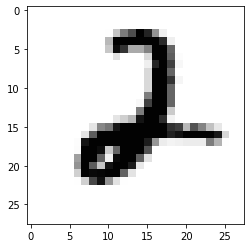

In [14]:
plt.imshow(img.reshape((28, 28)), cmap="Greys")

In [15]:
logits = saved_model.predict(img)
logits.argmax(axis=1)

array([2])

In [16]:
label

array([2])

In [0]:
def generate_importance_weights(d):
    weights = np.zeros((1, 28, 28, 1))

    r = 0
    while r < 28:
        c = 0
        while c < 28:
            rel = np.zeros((1, 28, 28, 1))
            rel[:, r:(r+d), c:(c+d), :] += img[:, r:(r+d), c:(c+d), :]

            irrel = img.copy()
            irrel[:, r:(r+d), c:(c+d), :] *= 0

            np.testing.assert_equal(img, rel + irrel)

            logits_rel, _ = model.predict([rel, irrel])

            weights[:, r:(r+d), c:(c+d), :] += logits_rel[0, label]

            c += d
        r += d
        
    return weights

Instead of visualizing raw logit values, we take a softmax over the entire map for the image, in order to get an importance map similar to what attention produces, for each pixel in the image.

In [0]:
sf = generate_importance_weights(1)

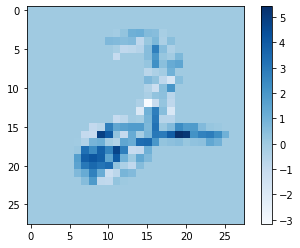

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(sf.reshape(28, 28), cmap="Blues")
fig.colorbar(mappable=im, ax=ax)

In [0]:
sf = generate_importance_weights(2)

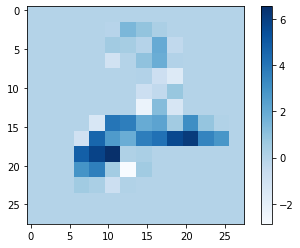

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(sf.reshape(28, 28), cmap="Blues")
fig.colorbar(mappable=im, ax=ax)

In [0]:
sf = generate_importance_weights(4)

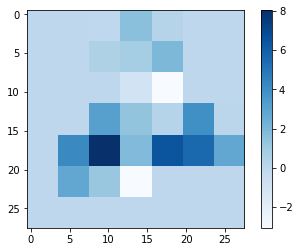

In [23]:
fig, ax = plt.subplots()
im = ax.imshow(sf.reshape(28, 28), cmap="Blues")
fig.colorbar(mappable=im, ax=ax)

In [0]:
sf = generate_importance_weights(6)

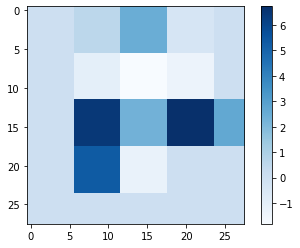

In [25]:
fig, ax = plt.subplots()
im = ax.imshow(sf.reshape(28, 28), cmap="Blues")
fig.colorbar(mappable=im, ax=ax)

In [0]:
sf = generate_importance_weights(8)

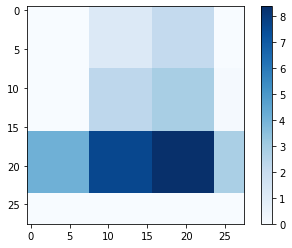

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(sf.reshape(28, 28), cmap="Blues")
fig.colorbar(mappable=im, ax=ax)